# Visualize Predictions

## Parameters

In [43]:
import torch

# set random seeds
torch.manual_seed(0)

In [44]:
config = '/home/Talen/foragefish_classifier/configs/exp_resnet18.yaml'
split = 'test'

## Load Data

In [45]:
import sys
sys.path.append('/home/Talen/foragefish_classifier')


In [46]:
import yaml
from train import create_dataloader, load_model       # NOTE: since we're using these functions across files, it could make sense to put them in e.g. a "util.py" script.

# load config
print(f'Using config "{config}"')
cfg = yaml.safe_load(open(config, 'r'))


# setup entities
dl_test = create_dataloader(cfg, split='test')

# load model
model, epoch = load_model(cfg)

Using config "/home/Talen/foragefish_classifier/configs/exp_resnet18.yaml"
Starting new model


/home/Talen/miniconda3/envs/cv4ecology2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Talen/miniconda3/envs/cv4ecology2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Visualize

This is up to you to figure out now. :)

In [59]:
from tqdm import trange

device = "cuda"
model.to(device) # puts model weights on to gpu
model.eval() # changes model to eval / inference mode

progressBar = trange(len(dl_test))
pred_all = []
argmax_all = []
img_list = []
for idx, (data, labels) in enumerate(dl_test):       # see the last line of file "dataset.py" where we return the image tensor (data) and label

    # put data and labels on device
    data, labels = data.to(device), labels.to(device)

    # forward pass
    prediction = model(data) 
    # visualize image that's stored in a batch in variable 'data' (this will be a for loop that iterates a batch)
    # use argmax() over the prediction in a single image, apply it to every image's corresponding prediction.
    #In a list, store labels. ANd then compare the g-t classes and prediction. Create a pandas dataframe with three columns: image_name, gt, and predictions. 
    
    # Now we use argmax() over the prediction pair of numbers, and apply it to every image's corresponding prediction.
    argmax = prediction.argmax(dim=1)

    print(argmax)
    
    # print(argmax)
    argmax_all.extend(argmax.detach().cpu().numpy())
    
    

    # store the prediction in a list
    # pred_all.append(prediction.detach().cpu().numpy()[0])
    pred_all.append(prediction.detach().cpu().numpy())
    img_list.extend(data)
    


# step 1 -visualize predictions + ground truth in matplotlib
# Step 2 - look up weights + biases, how to set them up in the model to log during training
# Step 3 - set up experiments so that when I start a new training run, it generates an experimental folder with the right name 
# copy config file to each experiment folder


  0%|          | 0/5 [00:31<?, ?it/s]


tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 1, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')


In [61]:
img_list


# Now we use argmax() over the prediction pair of numbers, and apply it to every image's corresponding prediction.




torch.Size([3, 224, 224])

In [49]:
# Now we make argmax into a list (same as pred_all) and print it:
print(argmax_all)

[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


In [50]:


# Now we make a list of our ground-truth labels:
gt_all = []
for idx, (data, labels) in enumerate(dl_test):
     gt_all.extend(labels.detach().cpu().numpy())

print(gt_all)




[np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


In [51]:
# Now we make a pandas dataframe with three columns: image_name, gt, and predictions.
import pandas as pd
# df = pd.DataFrame({'gt': gt_all, 'pred':argmax_all, 'raw_pred': pred_all})
df = pd.DataFrame({'gt': gt_all, 'pred':argmax_all})
print(df)

    gt  pred
0    1     0
1    0     0
2    0     0
3    1     0
4    0     0
5    0     0
6    1     0
7    0     0
8    0     0
9    0     0
10   0     0
11   1     0
12   1     1
13   1     0
14   1     0
15   1     0
16   0     0
17   1     0
18   0     0
19   1     0


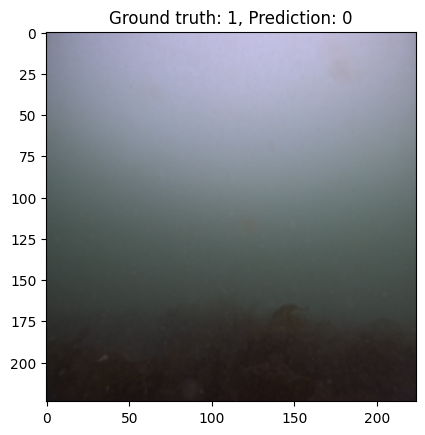

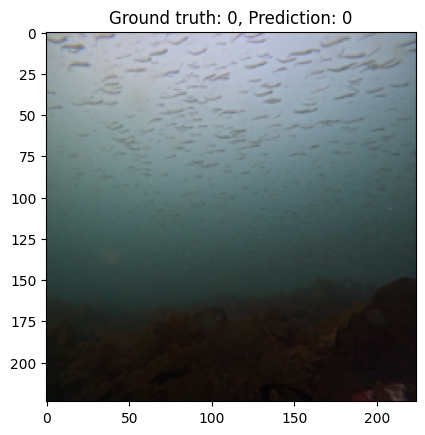

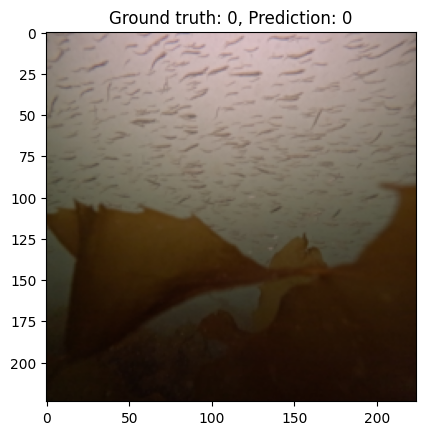

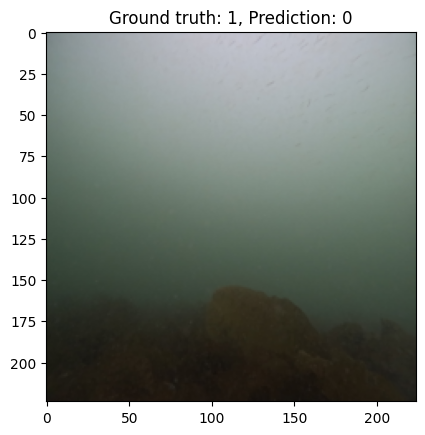

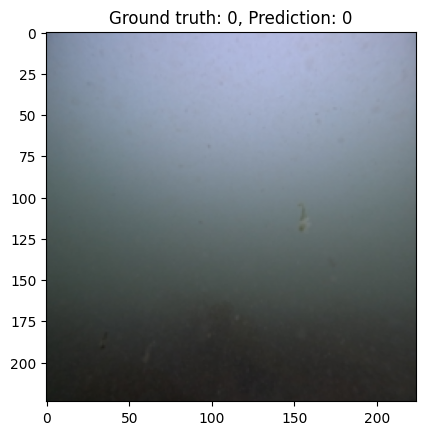

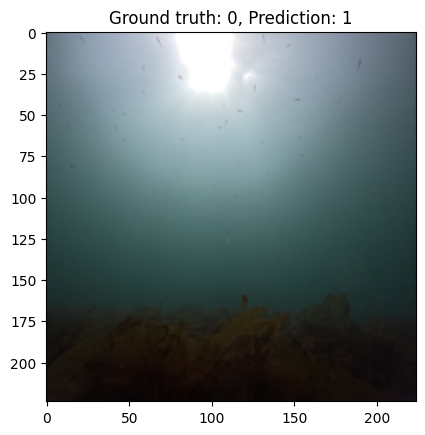

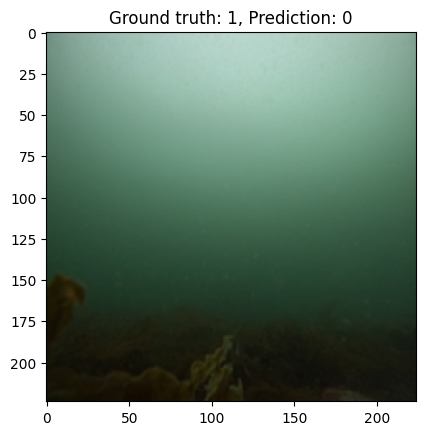

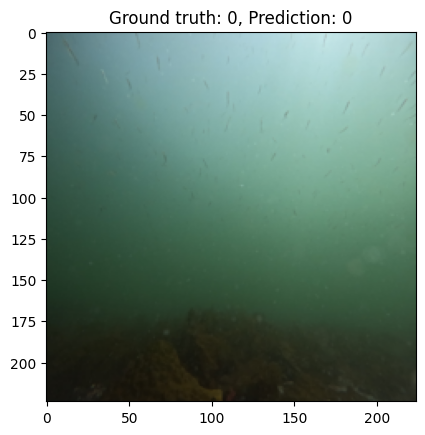

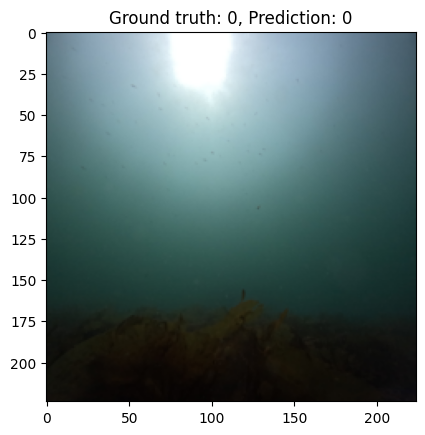

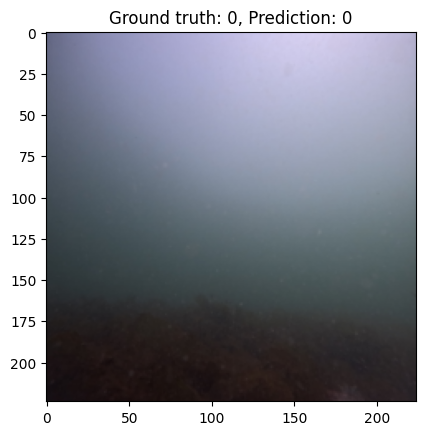

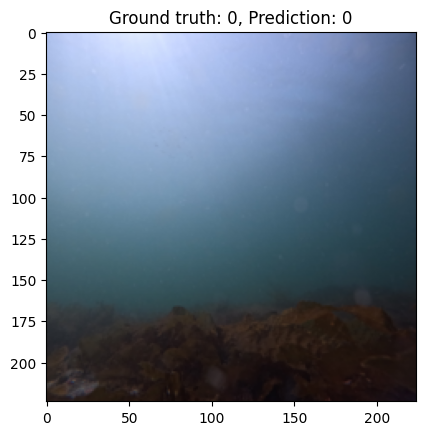

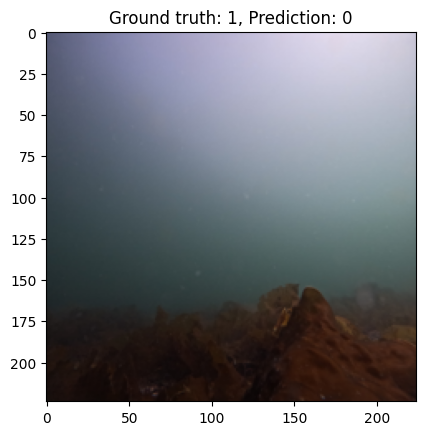

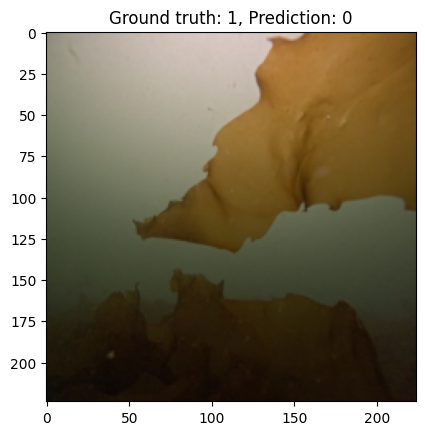

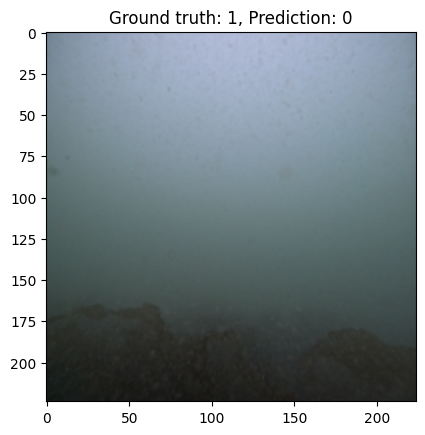

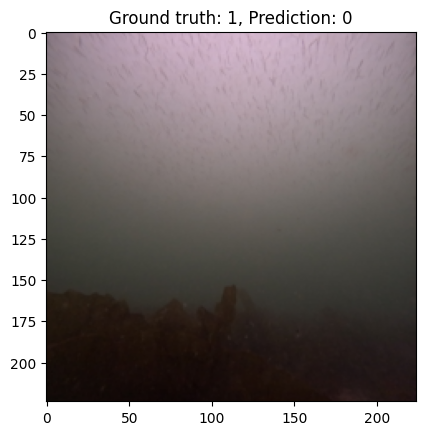

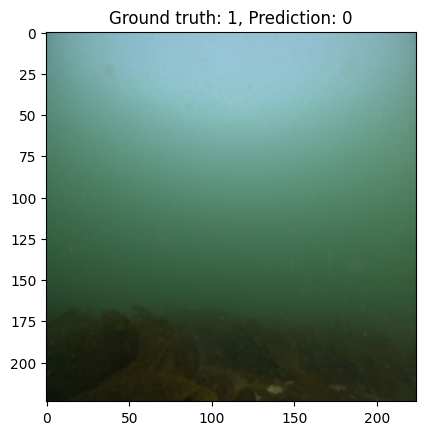

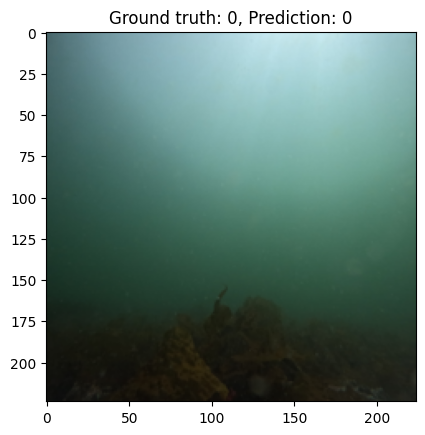

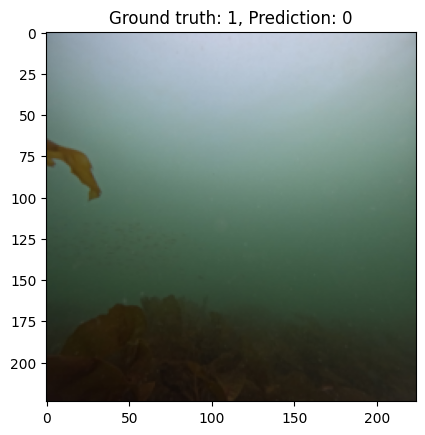

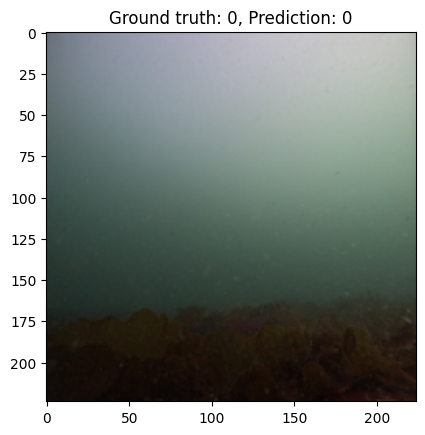

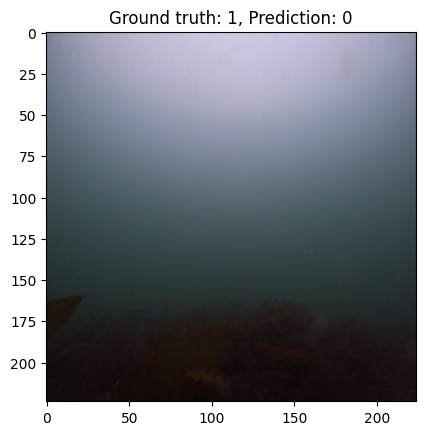

In [64]:
# Now we visualize the predictions and ground truth in matplotlib

import matplotlib.pyplot as plt
import numpy as np

# Let's visualize the first 10 images
# for i in range(10):
#     plt.imshow(data[i].permute(1,2,0))
#     plt.title(f'Ground truth: {gt_all[i]}, Prediction: {argmax_all[i]}')
#     plt.show()

# Now lets visualize all images in the dataset, with their ground truth and predictions:
# for i in range(len(df)):
#     plt.imshow(data[i].permute(1,2,0))
#     plt.title(f'Ground truth: {gt_all[i]}, Prediction: {argmax_all[i]}')
#     plt.show()

# This visualizes one batch of images, but we want to visualize all images in the dataset.
for i in range(len(df)):
    plt.imshow(img_list[i].cpu().permute(1,2,0))
    plt.title(f'Ground truth: {gt_all[i]}, Prediction: {argmax_all[i]}')
    plt.show()


     

In [53]:


import sklearn

ModuleNotFoundError: No module named 'sklearn'

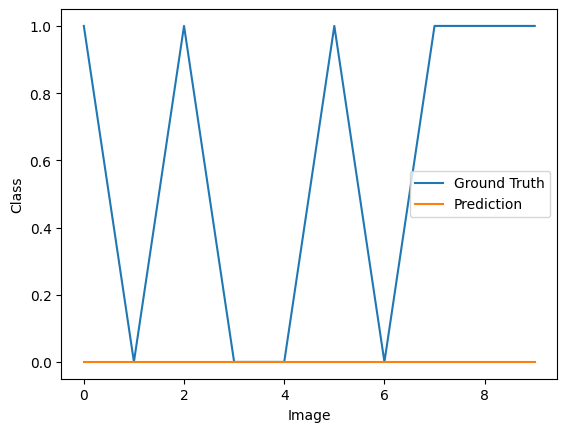

ModuleNotFoundError: No module named 'sklearn'

In [17]:
# Next steps: visualize and evaluate
# Visualize - look @ images and compare to prediction we got.

#Now we want to visualize the predictions and ground truth in matplotlib in a plot:
plt.plot(df['gt'], label='Ground Truth')
plt.plot(df['pred'], label='Prediction')
#give the x-axis a label
plt.xlabel('Image')
#give the y-axis a label
plt.ylabel('Class')
plt.legend()
plt.show()

import sklearn
print(sklearn.__version__)


# Now print the accuracy of the model:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df['gt'], df['pred'])
print(f'Accuracy: {accuracy}')




